In [1]:
import logging
import math
import os
from pathlib import Path
import re
from typing import Any, Optional

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
from scipy.interpolate import Rbf
import vedo

from histalign import set_log_level
from histalign.backend.io import (
    gather_alignment_paths,
    load_alignment_settings,
    load_image,
)
from histalign.backend.maths import (
    compute_normal,
    compute_normal_from_raw,
    compute_origin_from_orientation,
)
from histalign.backend.models import AlignmentSettings, Orientation
from histalign.backend.registration import Registrator
from histalign.backend.registration.alignment import (
    ALIGNMENT_VOLUMES_CACHE_DIRECTORY,
    generate_hash_from_targets,
)
from histalign.backend.workspace import Volume, VolumeSlicer

vedo.settings.default_backend = "vtk"

_module_logger = logging.getLogger("histalign.notebook")
# set_log_level("DEBUG")

In [2]:
Coordinates = np.ndarray  # Coordinates in NumPy form
CoordinatesTuple = tuple[int, ...]  # Coordinates in tuple form (OK as dictionary keys)
Projection = np.ndarray


def snap_coordinates(coordinates: Coordinates) -> Coordinates:
    return np.round(coordinates)


def get_normal_line_points(
    alignment_settings: AlignmentSettings,
) -> tuple[np.ndarray, np.ndarray]:
    alignment_normal = compute_normal(alignment_settings.volume_settings)

    edge_plane1 = vedo.Plane(
        pos=(0, 0, 0),
        normal=compute_normal_from_raw(
            0, 0, alignment_settings.volume_settings.orientation
        ),
        s=(1_000_000, 1_000_000),
    )
    edge_plane2 = vedo.Plane(
        pos=alignment_settings.volume_settings.shape,
        normal=compute_normal_from_raw(
            0, 0, alignment_settings.volume_settings.orientation
        ),
        s=(1_000_000, 1_000_000),
    )

    alignment_origin = compute_origin_from_orientation(
        tuple((np.array(alignment_settings.volume_settings.shape) - 1) / 2),
        alignment_settings.volume_settings,
    )
    intersection_line_coordinates = (
        alignment_origin - 1_000_000 * alignment_normal,
        alignment_origin + 1_000_000 * alignment_normal,
    )

    return (
        edge_plane1.intersect_with_line(*intersection_line_coordinates).T
        - 100 * alignment_normal,
        edge_plane2.intersect_with_line(*intersection_line_coordinates).T
        + 100 * alignment_normal,
    )


def sub_project_image_stack(
    image_stack: np.ndarray, groups: list[int]
) -> list[np.ndarray]:
    sub_projections = []

    for group in groups:
        sub_stack = image_stack[np.where(np.array(groups) == group)]
        sub_projection = np.max(sub_stack, axis=0)
        sub_projections.append(sub_projection)

    return sub_projections


def compute_closest_plane(
    target_planes: list[vedo.Plane], fixed_planes: list[vedo.Plane]
) -> list[int]:
    groups = []
    for plane in target_planes:
        distances = list(map(plane.distance_to, fixed_planes))
        distances = list(map(np.max, distances))
        groups.append(distances.index(min(distances)))

    return groups


def _snap_stack_to_grid(
    image_stack: np.ndarray, alignment_settings: AlignmentSettings
) -> dict[CoordinatesTuple, Projection]:
    match alignment_settings.volume_settings.orientation:
        case Orientation.CORONAL:
            orientation_axis_length = alignment_settings.volume_settings.shape[0]
        case Orientation.HORIZONTAL:
            orientation_axis_length = alignment_settings.volume_settings.shape[1]
        case Orientation.SAGITTAL:
            orientation_axis_length = alignment_settings.volume_settings.shape[2]
        case other:
            raise Exception(f"ASSERT NOT REACHED ({other})")

    # Normal as-if no pitch or yaw are applied
    flat_normal = compute_normal_from_raw(
        0, 0, alignment_settings.volume_settings.orientation
    )

    # Points describing the normal using the aligned pitch and yaw
    normal_line_points = get_normal_line_points(alignment_settings)
    print(normal_line_points)
    # Origin of the aligned image based on the offset
    alignment_origin = compute_origin_from_orientation(
        tuple((np.array(alignment_settings.volume_settings.shape) - 1) / 2),
        alignment_settings.volume_settings,
    )
    # Normal of the plane used for alignment
    alignment_normal = compute_normal(alignment_settings.volume_settings)

    # Intersection of the normal line and every plane orthogonal to flat normal
    free_floating_intersections = [
        vedo.Plane(
            pos=i * np.abs(flat_normal),
            normal=flat_normal,
            s=(1_000_000, 1_000_000),
        ).intersect_with_line(
            np.squeeze(normal_line_points[0]),
            np.squeeze(normal_line_points[1]),
        )
        for i in range(orientation_axis_length)
    ]

    # Intersections snapped to the closest grid point of the volume
    snapped_intersections = [
        snap_coordinates(point) for point in free_floating_intersections
    ]

    # Mock up a plane for each snapped intersection
    snapped_planes = [
        vedo.Plane(
            pos=point.tolist()[0], normal=alignment_normal, s=(1_000_000, 1_000_000)
        )
        for point in snapped_intersections
    ]

    # Mock up a plane for each Z-index of the stack
    # TODO: Obtain the real spacing
    z_distance = 500
    stack_spacing = z_distance / alignment_settings.volume_settings.resolution.value
    stack_planes = [
        vedo.Plane(
            pos=alignment_origin + i * alignment_normal * stack_spacing,
            normal=alignment_normal,
            s=(1_000_000, 1_000_000),
        )
        for i in range(-image_stack.shape[0] // 2 + 1, image_stack.shape[0] // 2 + 1)
    ]

    # Group Z-indices based on closest snapped intersection
    groups = compute_closest_plane(stack_planes, snapped_planes)
    sub_projection_coordinates = np.array(snapped_intersections)[groups]

    # Sub-project
    sub_projections = sub_project_image_stack(image_stack, groups)

    return {
        tuple(sub_projection_coordinates[i].tolist()[0]): sub_projections[i]
        for i in range(len(sub_projection_coordinates))
    }


def snap_array_to_grid(
    image_array: np.ndarray, alignment_settings: AlignmentSettings
) -> dict[CoordinatesTuple, Projection]:
    dimension_count = len(image_array.shape)
    if dimension_count < 2 or dimension_count > 3:
        raise ValueError(
            f"Unexpected shape of image array. Expected 2 or 3 dimensions, "
            f"got {dimension_count}."
        )

    if dimension_count == 3:
        # Z-stacks require a lot more work
        return _snap_stack_to_grid(image_array, alignment_settings)

    alignment_origin = compute_origin_from_orientation(
        tuple((np.array(alignment_settings.volume_settings.shape) - 1) / 2),
        alignment_settings.volume_settings,
    )
    alignment_origin = tuple(map(int, alignment_origin))

    return {alignment_origin: image_array}


def undo_padding(image: np.ndarray, mesh: vedo.Mesh) -> np.ndarray:
    unpadded_image = image[
        mesh.metadata["i_padding"][0] : image.shape[0] - mesh.metadata["i_padding"][1],
        mesh.metadata["j_padding"][0] : image.shape[1] - mesh.metadata["j_padding"][1],
    ]

    return unpadded_image


def get_plane_from_2d_image(
    image: np.ndarray,
    alignment_settings: AlignmentSettings,
    slicer: VolumeSlicer,
    origin: Optional[list[float]] = None,
) -> None:
    registrator = Registrator(True, True)
    registered_slice = registrator.get_forwarded_image(
        image, alignment_settings, origin
    )

    if alignment_settings.volume_settings.orientation == Orientation.HORIZONTAL:
        registered_slice = ndimage.rotate(registered_slice, 90, reshape=False)
    if alignment_settings.volume_settings.orientation != Orientation.SAGITTAL:
        registered_slice = ndimage.rotate(
            registered_slice, -alignment_settings.volume_settings.pitch, reshape=False
        )

    plane_mesh = slicer.slice(
        alignment_settings.volume_settings, origin=origin, return_mesh=True
    )

    registered_slice = undo_padding(registered_slice, plane_mesh)

    plane_mesh.pointdata["ImageScalars"] = registered_slice.flatten()

    return plane_mesh


def replace_path_parts(
    path: Path,
    channel_index: Optional[int] = None,
    channel_regex: Optional[str] = None,
    z_stack_regex: Optional[str] = None,
) -> Path:
    # Remove part of the file name that indicates the projection
    if z_stack_regex is not None:
        path = path.with_name(
            re.sub(
                z_stack_regex,
                "",
                path.name,
                count=1,
            ),
        )

    # Replace the channel index
    if channel_regex is not None:
        if channel_index is not None:
            path = path.with_name(
                re.sub(
                    channel_regex,
                    channel_regex.replace(r"\d", str(channel_index)),
                    path.name,
                    count=1,
                )
            )

    return path


def generate_aligned_planes(
    alignment_volume: Volume | vedo.Volume,
    alignment_paths: list[Path],
    channel_index: Optional[int] = None,
    channel_regex: Optional[str] = None,
    z_stack_regex: Optional[str] = None,
) -> list[vedo.Plane]:
    _module_logger.debug(f"Starting generation of aligned planes.")

    planes = []
    slicer = VolumeSlicer(volume=alignment_volume)

    for index, alignment_path in enumerate(alignment_paths):
        if index > 0 and index % 5 == 0:
            _module_logger.debug(f"Generating plane(s) for {alignment_path.name}...")

        alignment_settings = load_alignment_settings(alignment_path)

        histology_path_with_replacement = replace_path_parts(
            alignment_settings.histology_path,
            channel_index,
            channel_regex,
            z_stack_regex,
        )
        if not histology_path_with_replacement.exists():
            _module_logger.error(
                f"Could not find file '{histology_path_with_replacement}' "
                f"(original path: '{alignment_settings.histology_path}'). "
                f"Skipping it."
            )
            continue

        alignment_settings.histology_path = histology_path_with_replacement

        image_array = load_image(alignment_settings.histology_path, allow_stack=True)

        projections_map = snap_array_to_grid(image_array, alignment_settings)
        for origin, projection in projections_map.items():
            planes.append(
                get_plane_from_2d_image(
                    projection, alignment_settings, origin=origin, slicer=slicer
                )
            )

    _module_logger.debug(f"Finished generating all aligned planes.")
    return planes


def insert_aligned_planes_into_array(
    array: np.ndarray,
    planes: list[vedo.Plane],
    inplace: bool = True,
) -> np.ndarray:
    _module_logger.debug(
        f"Starting insertion of {len(planes)} planes into alignment array."
    )

    if not inplace:
        array = array.copy()

    for index, plane in enumerate(planes):
        if index > 0 and index % 5 == 0:
            _module_logger.debug(f"Inserted {index} planes into alignment array...")

        temporary_volume = vedo.Volume(np.zeros_like(array))
        temporary_volume.interpolate_data_from(plane, radius=1)

        temporary_array = temporary_volume.tonumpy()
        temporary_array = np.round(temporary_array).astype(np.uint16)

        array[:] = np.maximum(array, temporary_array)

    _module_logger.debug(
        f"Finished inserting all {len(planes)} planes into alignment array."
    )

    return array


def build_aligned_volume(
    alignment_directory: str | Path,
    use_cache: bool = True,
    return_raw_array: bool = False,
    channel_index: Optional[int] = None,
    channel_regex: Optional[str] = None,
    z_stack_regex: Optional[str] = None,
) -> np.ndarray | vedo.Volume:
    _module_logger.debug("Starting build of aligned volume.")

    if channel_regex is not None and channel_index is None:
        _module_logger.warning(
            "Received channel regex but no channel index. Building alignment "
            "volume using the same channel as was used for alignment."
        )
    elif channel_regex is None and channel_index is not None:
        _module_logger.warning(
            "Received channel index but no channel regex. Building alignment "
            "volume using the same channel as was used for alignment."
        )

    if isinstance(alignment_directory, str):
        alignment_directory = Path(alignment_directory)

    alignment_paths = gather_alignment_paths(alignment_directory)
    if not alignment_paths:
        raise ValueError("Cannot build aligned volume from empty alignment directory.")

    alignment_hash = generate_hash_from_targets(alignment_paths)

    cache_path = ALIGNMENT_VOLUMES_CACHE_DIRECTORY / f"{alignment_hash}.npz"
    if cache_path.exists() and use_cache:
        _module_logger.debug("Found cached aligned volume. Loading from file.")

        array = np.load(cache_path)["array"]
        if return_raw_array:
            return array
        return vedo.Volume(array)

    reference_shape = load_alignment_settings(alignment_paths[0]).volume_settings.shape

    # Volume needs to be created before array as vedo makes a copy
    aligned_volume = vedo.Volume(np.zeros(shape=reference_shape, dtype=np.uint16))
    aligned_array = aligned_volume.tonumpy()

    planes = generate_aligned_planes(
        aligned_volume, alignment_paths, channel_index, channel_regex, z_stack_regex
    )

    insert_aligned_planes_into_array(aligned_array, planes)
    aligned_volume.modified()  # Probably unnecessary but good practice

    if use_cache:
        _module_logger.debug("Caching volume to file as a NumPy array.")
        os.makedirs(ALIGNMENT_VOLUMES_CACHE_DIRECTORY, exist_ok=True)
        np.savez_compressed(cache_path, array=aligned_array)

    if return_raw_array:
        return aligned_array
    return aligned_volume


def imshow(
    image: np.ndarray,
    cmap: Optional[str] = None,
    title: str = "",
    colorbar: bool = False,
    full_range: bool = False,
    vmin: Optional[int | float] = None,
    vmax: Optional[int | float] = None,
    figsize: Optional[tuple[int, int]] = None,
    tight: bool = True,
) -> None:
    figure, axes = plt.subplots(figsize=figsize)

    if full_range:
        try:
            vmin = np.iinfo(image.dtype).min
        except ValueError:
            vmin = np.finfo(image.dtype).min
        try:
            vmax = np.iinfo(image.dtype).max
        except ValueError:
            vmax = np.finfo(image.dtype).max

    image = axes.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    axes.axis(False)

    if title:
        figure.suptitle(title)
    if colorbar:
        plt.colorbar(image, ax=axes)

    if tight:
        plt.tight_layout()
    plt.show()


def show(
    volumes: vedo.CommonVisual | list[vedo.CommonVisual],
    camera: dict[str, Any] | None = None,
) -> None:
    if isinstance(volumes, vedo.CommonVisual):
        volumes = [volumes]

    plotter = vedo.Plotter(axes=3, interactive=True, screensize=(1920, 1080))
    for volume in volumes:
        plotter.add(volume)

    plotter.show(camera=camera)

In [3]:
alignment_directory = "/home/ediun/git/histalign/projects/project_z_stack/1ebb0c1a09"
planes = build_aligned_volume(
    alignment_directory,
    use_cache=False,
    z_stack_regex="_max",
)

(array([7.07159781e+05, 7.07145781e+05, 5.60000000e+01]), array([-7.07053781e+05, -7.07067781e+05,  5.60000000e+01]))


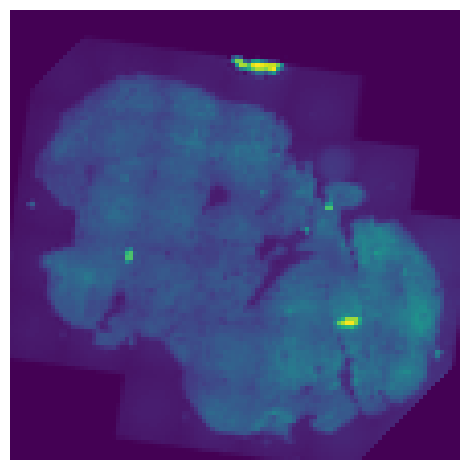

In [4]:
imshow(planes[0].pointdata["ImageScalars"].reshape(planes[0].metadata["shape"]))


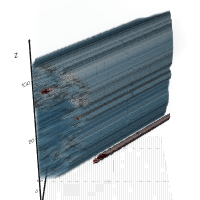

In [5]:
bounds = planes[0].bounds()
bounds = (
    math.floor(bounds[0] - np.sqrt(2)),
    math.ceil(bounds[1] + np.sqrt(2)),
    bounds[2],
    bounds[3],
    bounds[4],
    bounds[5],
)

dimensions = (
    round(bounds[1] - bounds[0]),
    round(bounds[3] - bounds[2]),
    round(bounds[5] - bounds[4]),
)
# dimensions = (
#     math.ceil(bounds[1]) - math.floor(bounds[0]),
#     math.ceil(bounds[3]) - math.floor(bounds[2]),
#     math.ceil(bounds[5]) - math.floor(bounds[4]),
# )

volume = planes[0].tovolume(
    radius=np.sqrt(2),
    bounds=bounds,
    dims=dimensions,
)
volume.interpolation(0)
volume

In [ ]:
main_volume = vedo.Volume(np.zeros(shape=(132, 80, 114), dtype=np.uint16))

In [ ]:
vedo.show(volume, axes=1)

In [7]:
# alignment_directory = "/home/ediun/git/histalign/projects/project_z_stack/1ebb0c1a09"
# aligned_volume = build_aligned_volume(
#     alignment_directory,
#     use_cache=False,
#     z_stack_regex="_max",
# )

In [8]:
# aligned_volume.cmap(c="red", alpha=[-0.5, 5])
# vedo.show(aligned_volume)